# Capacity prediction

## Notebook 4: Regression Model 

**Author:** ACG  
**Date:** `2024/06`  
**Version:** 1.0  

---

### Table of Contents
1. [Linear Regression](#linear-regression)
2. [DecisionTree Regression](#tree-regression)
3. [RandomForest Regression](#rf-regression)
4. [XGBoost](#xgb-regression)

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from utils.properties import *
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import statsmodels.api as sm
seed = 1862

## Import Dataset

In [3]:
df = pd.read_csv(DATASET_FINAL, sep=';')
df_target = df['capacity']
df_features = df.drop(['capacity'], axis=1)
# df = pd.read_csv(DATASET_FINAL_TRANSF, sep=';')

### FEATURE REDUCTION ###
# decision tree regressor
df_dtr_features = df.drop(['capacity','lowest_bound','median_complexity'
                          ,'std_complexity','max_harmonic_complexity','std_harmonic_complexity'
                          ,'avg_ent_w5','avg_occ_w10','avg_ent_w60','max_entriesInWindow_10','max_occupancyInWindow_10'
                          ,'max_entriesInWindow_60','day_from','year_from','year_to','duration_days'
                          ,'month_from','month_to'],axis=1)

In [4]:
df_target.describe()

count    588.000000
mean      32.005102
std        7.193479
min       15.000000
25%       26.000000
50%       32.000000
75%       37.000000
max       53.000000
Name: capacity, dtype: float64

In [5]:
df.isna().sum()

sector_area                   0
lowest_bound                  0
num_airblocks_avg             0
attitude_cruise_cruise        0
avg_nFlights                  0
median_complexity             0
std_complexity                0
max_harmonic_complexity       0
median_harmonic_complexity    0
std_harmonic_complexity       0
avg_occ_w5                    0
avg_ent_w5                    0
avg_occ_w10                   0
avg_ent_w60                   0
max_occupancyInWindow_10      0
max_entriesInWindow_10        0
max_entriesInWindow_60        0
duration_days                 0
year_from                     0
year_to                       0
atcunit_code                  0
sector_code                   0
ground                        0
ceiling                       0
volume_with_steps             0
is_tma                        0
month_from                    0
day_from                      0
month_to                      0
capacity                      0
dtype: int64

We want to start from a simple regression model, then go up from there.

In [6]:
X = sm.add_constant(df_features)
model = sm.OLS(df_target, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               capacity   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     24.68
Date:                Thu, 12 Sep 2024   Prob (F-statistic):           2.73e-81
Time:                        21:44:27   Log-Likelihood:                -1751.4
No. Observations:                 588   AIC:                             3563.
Df Residuals:                     558   BIC:                             3694.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

# 1. Linear Regression <a id="linear-regression"></a>

Because the model parameters have a relatively low correlation with the target (aprox. 40%), it suggests a weak linear correlation. The linear regression model is thus expected to perform the worst. Here we apply feature normalization with StandardScaler, but for the other models it is not required since they are tree based.

In [7]:
from sklearn.linear_model import LinearRegression

## Train

In [8]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)

In [9]:
scaler = StandardScaler()
algorithm = LinearRegression()

model_lr = Pipeline([
    ('scaler', scaler),
    ('algorithm', algorithm)
])
model_lr.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('algorithm', LinearRegression())])

In [10]:
y_pred = model_lr.predict(x_test)
y_train_pred = model_lr.predict(x_train)

## Evaluation

In [11]:
print(f"R^2 train: {model_lr.score(x_train,y_train)}")
print(f"R^2 test: {model_lr.score(x_test,y_test)}")
print(f"Number of parameters: {x_train.shape[1]}")
print(x_train.columns.tolist())

R^2 train: 0.5623012957435605
R^2 test: 0.530341453062143
Number of parameters: 29
['sector_area', 'lowest_bound', 'num_airblocks_avg', 'attitude_cruise_cruise', 'avg_nFlights', 'median_complexity', 'std_complexity', 'max_harmonic_complexity', 'median_harmonic_complexity', 'std_harmonic_complexity', 'avg_occ_w5', 'avg_ent_w5', 'avg_occ_w10', 'avg_ent_w60', 'max_occupancyInWindow_10', 'max_entriesInWindow_10', 'max_entriesInWindow_60', 'duration_days', 'year_from', 'year_to', 'atcunit_code', 'sector_code', 'ground', 'ceiling', 'volume_with_steps', 'is_tma', 'month_from', 'day_from', 'month_to']


As seen from the R squared, the model is capturing some of the target's variance but definetely not a large proportion. The similar results in train and test suggest there is no overfitting, however the low values could possibly represent underfitting, there is certainly room for improvement.

### Error

In [12]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE: train={mean_absolute_error(y_train,y_train_pred)}, test={mae}')
print(f'MSE: train={mean_squared_error(y_train,y_train_pred)}, test={mse}')
print(f'RMSE: train={mean_squared_error(y_train,y_train_pred)**0.5}, test={rmse}')

MAE: train=3.767948670306186, test=3.9478257290607126
MSE: train=22.906366266434006, test=22.38426904533727
RMSE: train=4.7860595761475855, test=4.731201649194132


On average the predictions with the linear model differ from the actual value by 3.86 units. The RMSE is more sensitive to larger errors then MAE, so a value of 4.66 after taking into account the MAE suggests that there are indeed larger errors, but they aren't extremely large.

### Plots

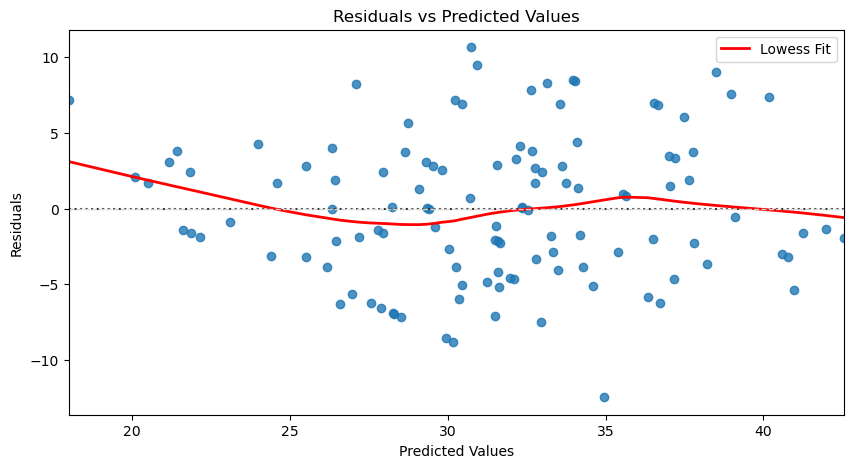

In [13]:
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2, 'label':'Lowess Fit'})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.savefig('../plots/lr_residuals.png') 
plt.show()

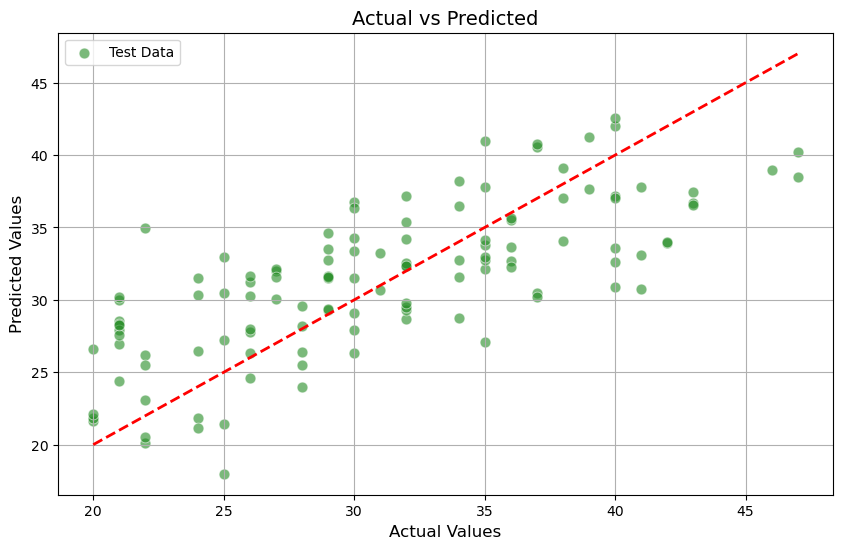

In [14]:
plt.figure(figsize=(10,6))

sbn.scatterplot(x=y_test, y=y_pred, s=60, color='forestgreen', alpha=0.6, label='Test Data')
# sbn.scatterplot(x=y_train, y=y_train_pred, s=60, color='teal', alpha=0.6, label='Train Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('../plots/lr_avp.png') 
plt.show()

# 2. DecisionTree Regression <a id="tree-regression"></a>

In [15]:
from sklearn.tree import DecisionTreeRegressor

In a decision tree model we will need to tune different hyperparameters to achieve optimal results:
1. **max_depth**: the depth of the tree, a greater value means more accuracy but also more computational time.
2. **min_samples_split**: the minimum number of samples required to split a node
3. **criterion**: function used to measure the quality of a split (Squared error, absolute error, etc.)

## Train

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df_dtr_features, df_target, test_size=0.2, random_state=seed)
tree_base = DecisionTreeRegressor(random_state=seed)

In [17]:
params = {
    'max_depth': [3,5,7,11],
    'min_samples_split': [3, 9, 12, 25, 80],
    'criterion': ["squared_error","poisson","absolute_error"]
}
metrics = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [18]:
gs = GridSearchCV(
    estimator=tree_base,
    param_grid=params,
    cv=5,
    scoring=metrics,
    refit='r2'
)
gs.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1862),
             param_grid={'criterion': ['squared_error', 'poisson',
                                       'absolute_error'],
                         'max_depth': [3, 5, 7, 11],
                         'min_samples_split': [3, 9, 12, 25, 80]},
             refit='r2',
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'mse': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

## Evaluation

In [19]:
results = pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_r2', ascending=False)
print(results.columns)
filter = ['params','mean_test_r2','mean_test_mae','mean_test_mse']
results[filter].head(10)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_split',
       'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae',
       'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae',
       'rank_test_mae', 'split0_test_mse', 'split1_test_mse',
       'split2_test_mse', 'split3_test_mse', 'split4_test_mse',
       'mean_test_mse', 'std_test_mse', 'rank_test_mse', 'split0_test_r2',
       'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2',
       'mean_test_r2', 'std_test_r2', 'rank_test_r2'],
      dtype='object')


,params,mean_test_r2,mean_test_mae,mean_test_mse
5,"{'criterion': 'squared_error', 'max_depth': 5,...",0.521187,3.713587,24.499425
12,"{'criterion': 'squared_error', 'max_depth': 7,...",0.518457,3.521859,24.492362
25,"{'criterion': 'poisson', 'max_depth': 5, 'min_...",0.515689,3.746823,24.883781
11,"{'criterion': 'squared_error', 'max_depth': 7,...",0.515374,3.485039,24.757991
31,"{'criterion': 'poisson', 'max_depth': 7, 'min_...",0.513368,3.487198,25.043768
32,"{'criterion': 'poisson', 'max_depth': 7, 'min_...",0.512114,3.554220,25.007560
6,"{'criterion': 'squared_error', 'max_depth': 5,...",0.505621,3.747098,25.216917
28,"{'criterion': 'poisson', 'max_depth': 5, 'min_...",0.505477,3.799190,25.348887
26,"{'criterion': 'poisson', 'max_depth': 5, 'min_...",0.504561,3.778907,25.406773
7,"{'criterion': 'squared_error', 'max_depth': 5,...",0.503534,3.765903,25.321690


In [20]:
# best GS model by accuracy
best_model_tr = gs.best_estimator_
y_pred = best_model_tr.predict(x_test)
y_pred_train = best_model_tr.predict(x_train)

print(best_model_tr)
print(f"parameters: {gs.best_params_}")
print(f"R^2 test: {gs.best_score_}")
print(f"R^2 train: {best_model_tr.score(x_train,y_train)}")

DecisionTreeRegressor(max_depth=5, min_samples_split=3, random_state=1862)
parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 3}
R^2 test: 0.5211874280828124
R^2 train: 0.7326349350679789


In [21]:
# comparison of best candidates
m1 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[5]
m2 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[12]
m3 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[25]
m4 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[11]
m5 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2','split4_test_r2']].iloc[31]

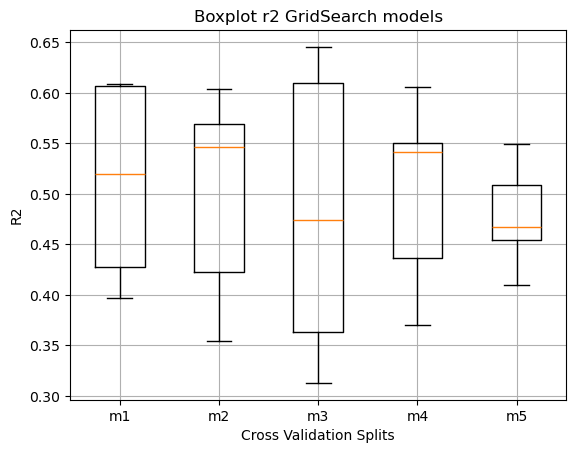

In [22]:
plt.boxplot([m1.values,m2.values,m3.values,m4.values,m5.values], labels=['m1','m2','m3','m4','m5'])
plt.title('Boxplot r2 GridSearch models')
plt.xlabel('Cross Validation Splits')
plt.ylabel('R2')
plt.grid(True)
plt.savefig('../plots/boxplot_dtr.png') 
plt.show()

The most robust model, the one with less variation, is also the model with the best r2, model at index 3.

In [23]:
# training with most robust params
params = {
    'min_samples_split': results.iloc[31]['param_min_samples_split'],
    'criterion': results.iloc[31]['param_criterion'],
    'max_depth': results.iloc[31]['param_max_depth'],
}
tr_best = DecisionTreeRegressor(**params)
tr_best.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=25)

In [24]:
y_pred_train = tr_best.predict(x_train)
y_pred_test = tr_best.predict(x_test)

rmse_train = mean_squared_error(y_train,y_pred_train) ** 0.5
rmse_test = mean_squared_error(y_test,y_pred_test) ** 0.5
print(f"Train \tR^2={r2_score(y_train, y_pred_train)}, MAE={mean_absolute_error(y_train,y_pred_train)}, RMSE={rmse_train}")
print(f"Test \tR^2={r2_score(y_test,y_pred_test)}, MAE={mean_absolute_error(y_test,y_pred_test)}, RMSE={rmse_test}")
print(f"Number of parameters: {x_train.shape[1]}")
print(x_train.columns.tolist())

Train 	R^2=0.5986346152202325, MAE=3.651215519599543, RMSE=4.583111543202635
Test 	R^2=0.5460767897205847, MAE=3.8708759838366618, RMSE=4.6512698716058365
Number of parameters: 12
['sector_area', 'num_airblocks_avg', 'attitude_cruise_cruise', 'avg_nFlights', 'median_harmonic_complexity', 'avg_occ_w5', 'atcunit_code', 'sector_code', 'ground', 'ceiling', 'volume_with_steps', 'is_tma']


The MAE is slightly lower then the previous model, however the RMSE is slightly higher.

### Plots

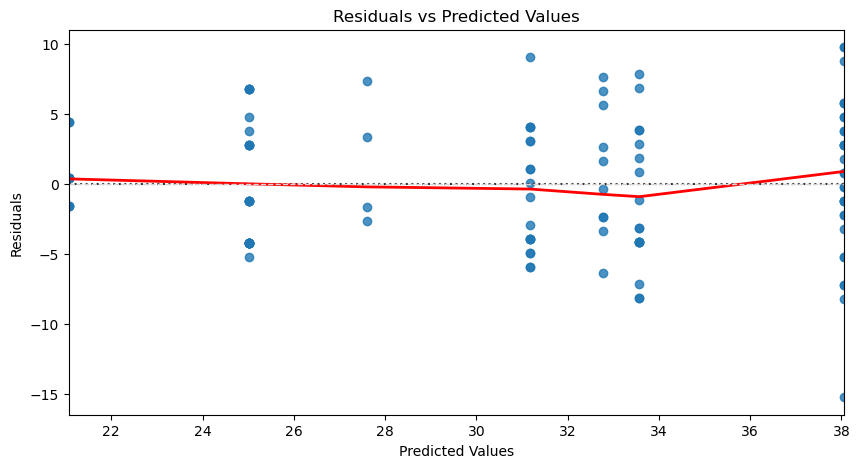

In [25]:
residuals = y_test - y_pred_test
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('../plots/tree_rvp.png') 
plt.show()

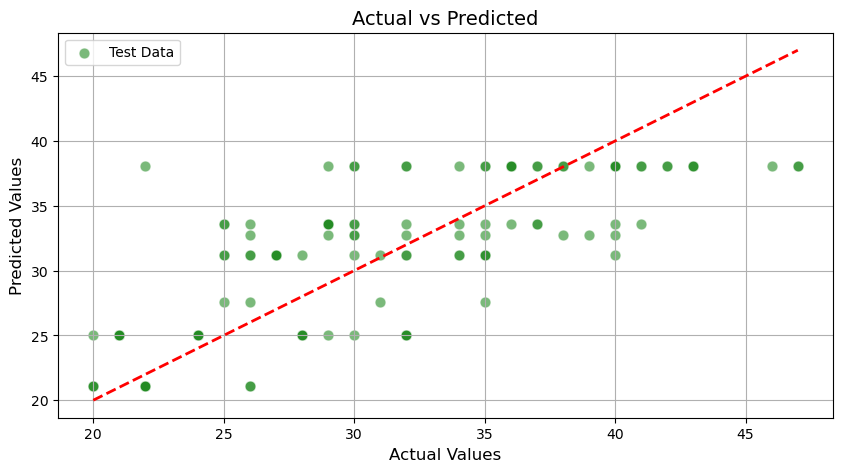

In [26]:
plt.figure(figsize=(10,5))
sbn.scatterplot(x=y_test, y=y_pred_test, s=60, color='forestgreen', alpha=0.6, label='Test Data')
# sbn.scatterplot(x=y_train, y=y_train_pred, s=60, color='teal', alpha=0.6, label='Train Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('../plots/tree_avp.png') 
plt.show()

# 3. Random Forest <a id="rf-regression"></a>

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)
rf_base = RandomForestRegressor(random_state=seed)

In [29]:
params = {
    'n_estimators': [50,100,150],
    'max_depth':[3,5,10,20],
    'min_samples_split':[2,5,10],
    'min_samples_leaf': [1,2,4,10]
}
metrics = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}
grid = GridSearchCV(
    estimator=rf_base,
    param_grid=params,
    cv=5,
    scoring=metrics,
    refit='r2'
)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1862),
             param_grid={'max_depth': [3, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             refit='r2',
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'mse': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

### Evaluation

In [30]:
results = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_r2', ascending=False)
print(results.columns)
filter = ['params','mean_test_r2','mean_test_mae','mean_test_mse']
results[filter].head(20)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_mae', 'split1_test_mae',
       'split2_test_mae', 'split3_test_mae', 'split4_test_mae',
       'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_mse',
       'split1_test_mse', 'split2_test_mse', 'split3_test_mse',
       'split4_test_mse', 'mean_test_mse', 'std_test_mse', 'rank_test_mse',
       'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2',
       'split4_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'],
      dtype='object')


,params,mean_test_r2,mean_test_mae,mean_test_mse
109,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.690581,3.014361,16.053897
112,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.689584,3.039522,16.110215
72,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.689104,3.060066,16.200360
110,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.687783,3.016447,16.188654
108,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.687399,3.054454,16.284785
113,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.687009,3.038501,16.236949
111,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.686236,3.064311,16.334374
73,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.686053,3.049284,16.289244
74,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.684678,3.044163,16.353783
76,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.683755,3.074477,16.403961


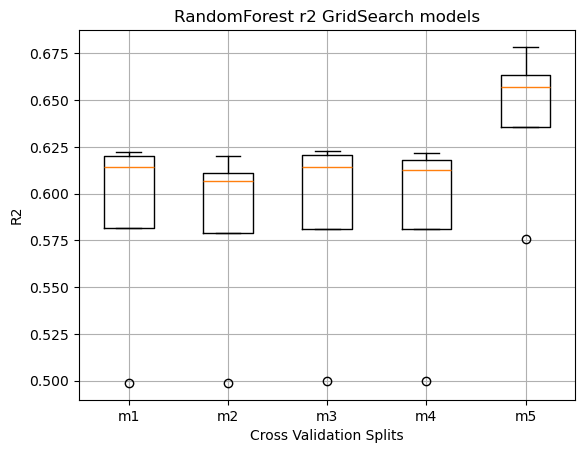

In [31]:
# best candidates
m1 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[109]
m2 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[112]
m3 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[110]
m4 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[113]
m5 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[74]

plt.boxplot([m1.values,m2.values,m3.values,m4.values,m5.values], labels=['m1','m2','m3','m4','m5'])
plt.title('RandomForest r2 GridSearch models')
plt.xlabel('Cross Validation Splits')
plt.ylabel('R2')
plt.grid(True)
plt.savefig('../plots/boxplot_rf.png') 
plt.show()

In [32]:
# training with most robust params
params = {
    'min_samples_split': results.iloc[74]['param_min_samples_split'],
    'min_samples_leaf': results.iloc[74]['param_min_samples_leaf'],
    'max_depth': results.iloc[74]['param_max_depth'],
    'n_estimators': results.iloc[74]['param_n_estimators']
}
rf_best = RandomForestRegressor(**params)
rf_best.fit(x_train,y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=150)

In [33]:
y_pred_train = rf_best.predict(x_train)
y_pred_test = rf_best.predict(x_test)

rmse_train = mean_squared_error(y_train,y_pred_train) ** 0.5
rmse_test = mean_squared_error(y_test,y_pred_test) ** 0.5
print(f"Train \tR^2={r2_score(y_train, y_pred_train)}, MAE={mean_absolute_error(y_train,y_pred_train)}, RMSE={rmse_train}")
print(f"Test \tR^2={r2_score(y_test,y_pred_test)}, MAE={mean_absolute_error(y_test,y_pred_test)}, RMSE={rmse_test}")
print(f"Number of parameters: {x_train.shape[1]}")
print(x_train.columns.tolist())
print(f"hyperparameters: {params}")

Train 	R^2=0.7950811909820791, MAE=2.479407177108499, RMSE=3.2747743601461927
Test 	R^2=0.660206101024247, MAE=3.21183090002657, RMSE=4.024279459036979
Number of parameters: 29
['sector_area', 'lowest_bound', 'num_airblocks_avg', 'attitude_cruise_cruise', 'avg_nFlights', 'median_complexity', 'std_complexity', 'max_harmonic_complexity', 'median_harmonic_complexity', 'std_harmonic_complexity', 'avg_occ_w5', 'avg_ent_w5', 'avg_occ_w10', 'avg_ent_w60', 'max_occupancyInWindow_10', 'max_entriesInWindow_10', 'max_entriesInWindow_60', 'duration_days', 'year_from', 'year_to', 'atcunit_code', 'sector_code', 'ground', 'ceiling', 'volume_with_steps', 'is_tma', 'month_from', 'day_from', 'month_to']
hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'n_estimators': 150}


### Plots

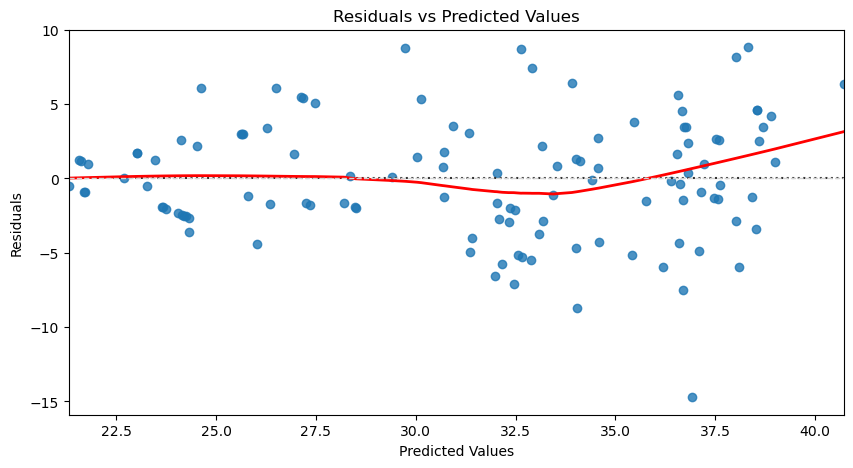

In [34]:
residuals = y_test - y_pred_test
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('../plots/rf_rvp.png') 
plt.show()

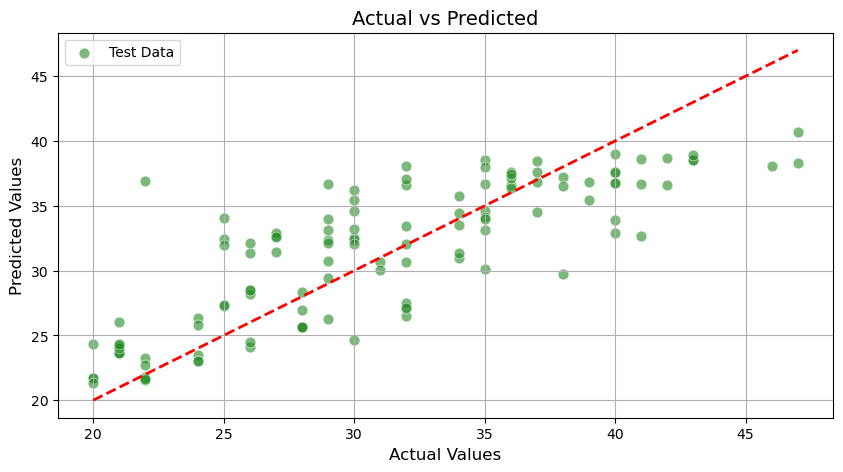

In [35]:
plt.figure(figsize=(10,5))
sbn.scatterplot(x=y_test, y=y_pred_test, s=60, color='forestgreen', alpha=0.6, label='Test Data')
# sbn.scatterplot(x=y_train, y=y_train_pred, s=60, color='teal', alpha=0.6, label='Train Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('../plots/rf_avp.png') 
plt.show()

# 4. XGBoost <a id="xgb-regression"></a>

In [36]:
from xgboost import XGBRegressor

### Train

We will tune the following parameters:
1. **n_estimators**: the number of trees the algorithm will build
2. **eta**: learning rate, it affects the contribution of each tree to the final model
3. **max_depth**: maximum depth of each tree
4. **alpha**: adds L1 regularization
5. **lambda**: adds L2 regularization

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)

In [38]:
xgb_base = XGBRegressor(random_state=seed)
params = {
    'n_estimators': [50,100,200],
    'max_depth':[3,5,7],
    'eta': [0.01,0.1,0.4],
    'alpha':[1,2,5,10,12],
    'lambda':[1,2,5,10,12]
}
metrics = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [39]:
grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=4,
    scoring=metrics,
    refit='r2'
)
grid_xgb.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    random_state=1862, ...),
             param_grid={'alpha': [1, 2, 5, 10, 12], 'eta': [0.01, 0.1, 0.4],
                         'lambda': [1, 2, 5, 10, 12], 'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             refit='r2',
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'mse': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

### Evaluation

In [40]:
pd.set_option('display.max_rows', None)

In [41]:
results = pd.DataFrame(grid_xgb.cv_results_).sort_values(by='mean_test_r2', ascending=False)
print(results.columns)
filter = ['params','mean_test_r2','mean_test_mae','mean_test_mse']
results[filter]

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_eta', 'param_lambda', 'param_max_depth',
       'param_n_estimators', 'params', 'split0_test_mae', 'split1_test_mae',
       'split2_test_mae', 'split3_test_mae', 'mean_test_mae', 'std_test_mae',
       'rank_test_mae', 'split0_test_mse', 'split1_test_mse',
       'split2_test_mse', 'split3_test_mse', 'mean_test_mse', 'std_test_mse',
       'rank_test_mse', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2',
       'split3_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'],
      dtype='object')


,params,mean_test_r2,mean_test_mae,mean_test_mse
238,"{'alpha': 2, 'eta': 0.4, 'lambda': 2, 'max_dep...",0.724022,2.769473,14.391789
239,"{'alpha': 2, 'eta': 0.4, 'lambda': 2, 'max_dep...",0.724022,2.769473,14.391789
237,"{'alpha': 2, 'eta': 0.4, 'lambda': 2, 'max_dep...",0.723665,2.772268,14.409908
341,"{'alpha': 5, 'eta': 0.1, 'lambda': 5, 'max_dep...",0.717782,2.783088,14.772866
59,"{'alpha': 1, 'eta': 0.1, 'lambda': 2, 'max_dep...",0.716889,2.758208,14.784027
221,"{'alpha': 2, 'eta': 0.1, 'lambda': 12, 'max_de...",0.716427,2.781919,14.834242
340,"{'alpha': 5, 'eta': 0.1, 'lambda': 5, 'max_dep...",0.715602,2.801039,14.888041
68,"{'alpha': 1, 'eta': 0.1, 'lambda': 5, 'max_dep...",0.715584,2.788886,14.826518
194,"{'alpha': 2, 'eta': 0.1, 'lambda': 2, 'max_dep...",0.714278,2.794075,14.942167
320,"{'alpha': 5, 'eta': 0.1, 'lambda': 1, 'max_dep...",0.713952,2.845609,14.940769


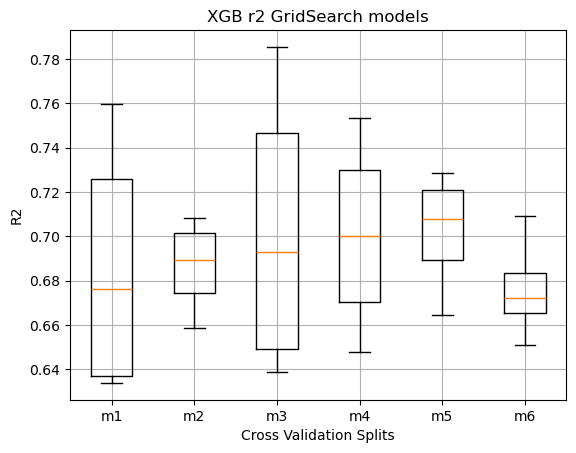

In [42]:
# best candidates
m1 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[238]
m2 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[239]
m3 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[59]
m4 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[77]
m5 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[62]
m6 = results[['split0_test_r2','split1_test_r2','split2_test_r2','split3_test_r2']].iloc[341]

plt.boxplot([m1.values,m2.values,m3.values,m4.values,m5.values,m6.values], labels=['m1','m2','m3','m4','m5','m6'])
plt.title('XGB r2 GridSearch models')
plt.xlabel('Cross Validation Splits')
plt.ylabel('R2')
plt.grid(True)
plt.savefig('../plots/boxplot_xgb.png') 
plt.show()

In [43]:
# best estimator
y_pred_train = grid_xgb.predict(x_train)
y_pred_test = grid_xgb.predict(x_test)

rmse_train = mean_squared_error(y_train,y_pred_train) ** 0.5
rmse_test = mean_squared_error(y_test,y_pred_test) ** 0.5
print(f"Train \tR^2={r2_score(y_train, y_pred_train)}, MAE={mean_absolute_error(y_train,y_pred_train)}, RMSE={rmse_train}")
print(f"Test \tR^2={r2_score(y_test,y_pred_test)}, MAE={mean_absolute_error(y_test,y_pred_test)}, RMSE={rmse_test}")

Train 	R^2=0.9987377524375916, MAE=0.17033970000896048, RMSE=0.2570165520145
Test 	R^2=0.7427961826324463, MAE=2.383947986667439, RMSE=3.5012174562133587


In [44]:
print(grid_xgb.best_estimator_)
print(f"parameters: {grid_xgb.best_params_}")
print(f"R squared: {grid_xgb.best_score_}")

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=2,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100, ...)
parameters: {'alpha': 2, 'eta': 0.4, 'lambda': 2, 'max_depth': 5, 'n_estimators': 100}
R squared: 0.7240218818187714


In [45]:
# training with m59 params
params = {
    'alpha': results.iloc[62]['param_alpha'],
    'eta': results.iloc[62]['param_eta'],
    'lambda': results.iloc[62]['param_lambda'],
    'max_depth': results.iloc[62]['param_max_depth'],
    'n_estimators': results.iloc[62]['param_n_estimators']
}
xgb_best = XGBRegressor(**params)
xgb_best.fit(x_train,y_train)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=10,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200, ...)

In [46]:
y_pred_train = xgb_best.predict(x_train)
y_pred_test = xgb_best.predict(x_test)

rmse_train = mean_squared_error(y_train,y_pred_train) ** 0.5
rmse_test = mean_squared_error(y_test,y_pred_test) ** 0.5
print(f"Train \tR^2={r2_score(y_train, y_pred_train)}, MAE={mean_absolute_error(y_train,y_pred_train)}, RMSE={rmse_train}")
print(f"Test \tR^2={r2_score(y_test,y_pred_test)}, MAE={mean_absolute_error(y_test,y_pred_test)}, RMSE={rmse_test}")
print(f"Number of parameters: {x_train.shape[1]}")
print(x_train.columns.tolist())
print(f"hyperparameters: {params}")

Train 	R^2=0.9991471767425537, MAE=0.1281406321424119, RMSE=0.21125968232114145
Test 	R^2=0.7579628229141235, MAE=2.4622682636067017, RMSE=3.3964198909517465
Number of parameters: 29
['sector_area', 'lowest_bound', 'num_airblocks_avg', 'attitude_cruise_cruise', 'avg_nFlights', 'median_complexity', 'std_complexity', 'max_harmonic_complexity', 'median_harmonic_complexity', 'std_harmonic_complexity', 'avg_occ_w5', 'avg_ent_w5', 'avg_occ_w10', 'avg_ent_w60', 'max_occupancyInWindow_10', 'max_entriesInWindow_10', 'max_entriesInWindow_60', 'duration_days', 'year_from', 'year_to', 'atcunit_code', 'sector_code', 'ground', 'ceiling', 'volume_with_steps', 'is_tma', 'month_from', 'day_from', 'month_to']
hyperparameters: {'alpha': 2, 'eta': 0.4, 'lambda': 10, 'max_depth': 7, 'n_estimators': 200}


### Plots

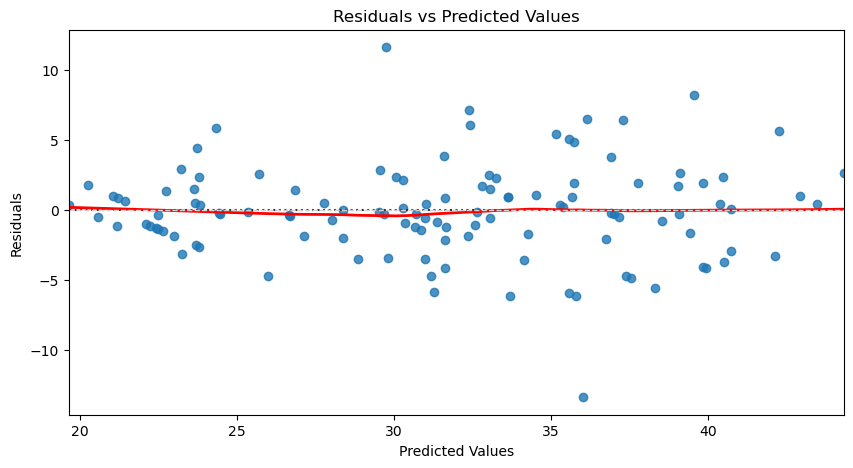

In [47]:
residuals = y_test - y_pred_test
plt.figure(figsize=(10,5))
sbn.residplot(x=y_pred_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('../plots/xgb_rvp.png') 
plt.show()

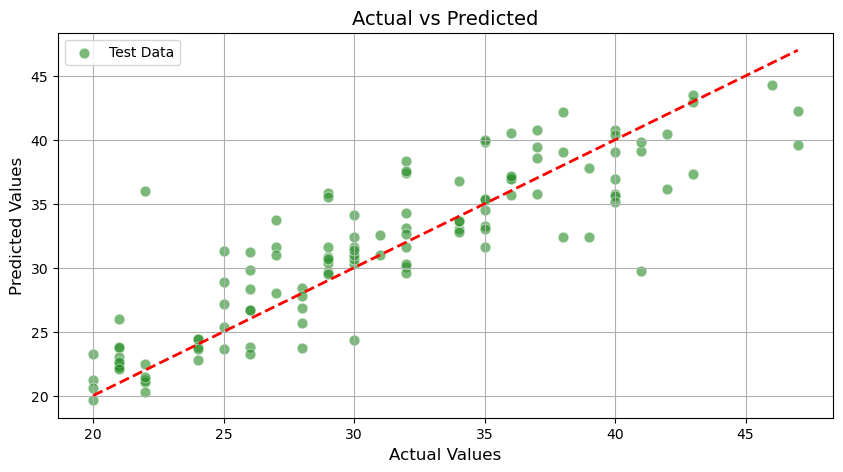

In [48]:
plt.figure(figsize=(10,5))
sbn.scatterplot(x=y_test, y=y_pred_test, s=60, color='forestgreen', alpha=0.6, label='Test Data')
# sbn.scatterplot(x=y_train, y=y_train_pred, s=60, color='teal', alpha=0.6, label='Train Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Actual vs Predicted', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('../plots/xgb_avp.png') 
plt.show()